In [1]:
import pickle
import numpy as np
import xarray as xr
import pandas as pd

import dask
import dask.array as da
from dask import delayed

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import dates as mdates
import matplotlib.patheffects as PathEffects
from matplotlib.gridspec import GridSpec

import cartopy.crs as ccrs
import cartopy.feature as cfeature

from scipy.ndimage.measurements import center_of_mass
from scipy.stats import mannwhitneyu, pearsonr, levene

from glob import glob

from datetime import datetime, timedelta

import scipy.stats as stats

ERROR 1: PROJ: proj_create_from_database: Open of /home/bwallace/anaconda3/envs/analysis/share/proj failed
/var/tmp/pbs.1882978.polaris-pbs-01.hsn.cm.polaris.alcf.anl.gov/ipykernel_777204/3129694842.py:19: DeprecationWarning: Please use `center_of_mass` from the `scipy.ndimage` namespace, the `scipy.ndimage.measurements` namespace is deprecated.
  from scipy.ndimage.measurements import center_of_mass


In [2]:
simulation_color_codes = {'historical': '#c7e9c0', 
                          'future_4p5': '#6baed6', 
                          'future_8p5': '#a50f15'}

#modify the default boxplot
meanpointprops = dict(marker='.', markeredgecolor='black',
                      markerfacecolor='black')

y_labs={
    'area':' Area $\geq$ 20 dBZ',
    'convection_area':' Area $\geq$ 40 dBZ',
    'intense_area':' Area $\geq$ 50 dBZ',
    'duration':' Storm Duration',
    'mean_intensity':' Intensity',
    'max_intensity':' Maximum Intensity',
    'speed':' Speed',
}

y_units={
    'area':'km$^{2}$',
    'convection_area':'km$^{2}$',
    'intense_area':'km$^{2}$',
    'duration':'hours',
    'mean_intensity':'dBZ',
    'max_intensity':'dBZ',
    'speed':'m s$^{-1}$',
}

season_months={
    'DJF':[12,1,2],
    'MAM':[3,4,5],
    'JJA':[6,7,8],
    'SON':[9,10,11],
    'ALL':np.arange(1,13),
}

letters=['a)','b)','c)','d)','e)','f)','g)','h)','i)','j)']

import matplotlib.lines as mlines

rc45_mark_mwu = mlines.Line2D([], [], color='k', marker='^', linestyle='None',
                          markersize=8)

rc85_mark_mwu = mlines.Line2D([], [], color='k', marker='s', linestyle='None',
                          markersize=8)

rc85_mark_mwu_force = mlines.Line2D([], [], color='k', marker='^', linestyle='None',
                          markersize=8)

rc85_mark_mwu_unforce = mlines.Line2D([], [], color='k', marker='*', linestyle='None',
                          markersize=12)

In [3]:
with open('../data/boxplot_stats.pkl', 'rb') as f:
    # Load the dictionary from the pickle file
    data_store = pickle.load(f)

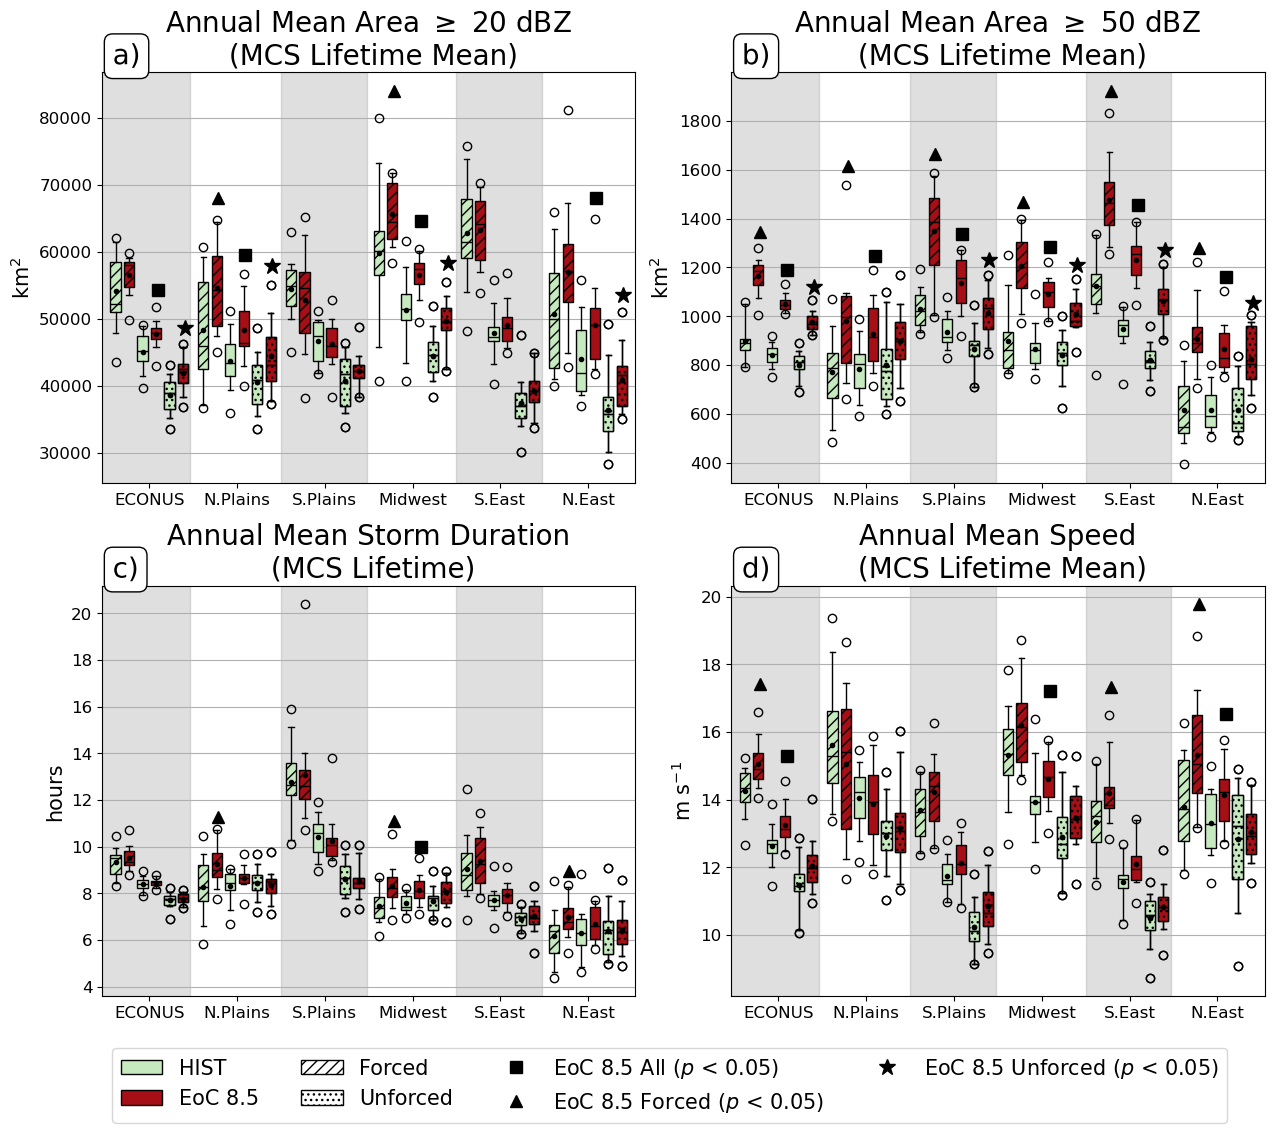

In [4]:
v_list=['area','intense_area','duration','speed']

plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['axes.labelsize'] = 12


#for season in ['ALL','DJF','MAM','JJA','SON']:
for season in ['ALL']:
    
    if season=='ALL':
        slabel='Annual'
    else:
        slabel=season

    fig,axs=plt.subplots(2,2)

    fig.set_figheight(12)
    fig.set_figwidth(15)

    for v_i,v in enumerate(v_list):

        ax=axs[v_i//2,v_i%2]

        ax.axvspan(-0.7, 0.6, color='grey', alpha=0.25)
        ax.axvspan(1.95, 3.22, color='grey', alpha=0.25)
        ax.axvspan(4.55, 5.82, color='grey', alpha=0.25)

        ax.set_ylabel(y_units[v],fontsize=15)

        ax.set_xlim(-0.7, 7.2)

        plot_data={}
        for ur_i,ur in enumerate(['Undefined','Northern Plains','Southern Plains',
                                 'Midwest','Southeast','Northeast']):
            if ur=='Undefined':
                label='ECONUS'
            else:
                label=ur

            if ur_i:
                ur_i = ur_i + (0.3 * ur_i)


            bplot_hatches = \
                            ax.boxplot([data_store['Unforced'+'_'+season+'_'+'historical_'+v+'_'+ur].values,
                            data_store['Unforced'+'_'+season+'_'+'future_8p5_'+v+'_'+ur].values],
                            positions=[ur_i+0.3,ur_i+0.5],#,ur_i+0.25],
                            labels=['', ''],
                            patch_artist=True,whis=[5,95],showmeans=True,
                            meanprops=meanpointprops, medianprops={'color':'black'})

            bplot2=ax.boxplot([data_store['Forced'+'_'+season+'_'+'historical_'+v+'_'+ur].values,
                             data_store['Forced'+'_'+season+'_'+'future_8p5_'+v+'_'+ur].values],
                       positions=[ur_i-0.5,ur_i-0.3],#,ur_i+0.25],
                       labels=['', ''],
                       patch_artist=True,whis=[5,95],showmeans=True,
                       meanprops=meanpointprops, medianprops={'color':'black'})

            bplot=ax.boxplot([data_store['All'+'_'+season+'_'+'historical_'+v+'_'+ur].values,
                             data_store['All'+'_'+season+'_'+'future_8p5_'+v+'_'+ur].values],
                       positions=[ur_i-0.1,ur_i+0.1],#,ur_i+0.25],
                       labels=['',label.replace(' ','\n')],
                       patch_artist=True,whis=[5,95],showmeans=True,
                       meanprops=meanpointprops, medianprops={'color':'black'})

            bplot3=ax.boxplot([data_store['Unforced'+'_'+season+'_'+'historical_'+v+'_'+ur].values,
                             data_store['Unforced'+'_'+season+'_'+'future_8p5_'+v+'_'+ur].values],
                       positions=[ur_i+0.3,ur_i+0.5],#,ur_i+0.25],
                       labels=['', ''],
                       patch_artist=True,whis=[5,95],showmeans=True,
                       meanprops=meanpointprops, medianprops={'color':'black'})





            plt.setp(bplot['medians'], color='black')
            [item.set_color('black') for item in bplot['means']] 

            for sim, patch in zip(['historical', 'future_8p5'], bplot['boxes']):
                patch.set_facecolor(simulation_color_codes[sim])
            for sim, patch in zip(['historical', 'future_8p5'], bplot2['boxes']):
                patch.set_facecolor(simulation_color_codes[sim])
                patch.set(hatch='///')
            for sim, patch in zip(['historical', 'future_8p5'], bplot3['boxes']):
                patch.set_facecolor(simulation_color_codes[sim])
                patch.set(hatch='...')
            for sim, patch in zip(['historical', 'future_8p5'], bplot_hatches['boxes']):
                patch.set_facecolor('w')
                if sim=='historical':
                    patch.set(hatch='///')
                else:
                    patch.set(hatch='...')


            _, ph85 = mannwhitneyu(data_store['All'+'_'+season+'_historical_'+v+'_'+ur].values,
                                   data_store['All'+'_'+season+'_future_8p5_'+v+'_'+ur].values)
            if ph85 < 0.05:
                m85 = ax.plot(ur_i+0.125, 1.05*np.max([data_store['All'+'_'+season+'_historical_'+v+'_'+ur].max(), 
                                                       data_store['All'+'_'+season+'_future_8p5_'+v+'_'+ur].max()]), 
                              "ks", ms=8)

            
            _, ph85 = mannwhitneyu(data_store['Forced'+'_'+season+'_historical_'+v+'_'+ur].values,
                                   data_store['Forced'+'_'+season+'_future_8p5_'+v+'_'+ur].values)
            if ph85 < 0.05:
                m85 = ax.plot(ur_i-0.275, 1.05*np.max([data_store['Forced'+'_'+season+'_historical_'+v+'_'+ur].max(), 
                                                       data_store['Forced'+'_'+season+'_future_8p5_'+v+'_'+ur].max()]), 
                              "k^", ms=8)

            _, ph85 = mannwhitneyu(data_store['Unforced'+'_'+season+'_historical_'+v+'_'+ur].values,
                                   data_store['Unforced'+'_'+season+'_future_8p5_'+v+'_'+ur].values)
            if ph85 < 0.05:
                m85 = ax.plot(ur_i+0.525, 1.05*np.max([data_store['Unforced'+'_'+season+'_historical_'+v+'_'+ur].max(), 
                                                       data_store['Unforced'+'_'+season+'_future_8p5_'+v+'_'+ur].max()]), 
                              "k*", ms=12)



            ax.set_xticks([0,1.3,2.6,3.9,5.2,6.5], labels=['ECONUS', 'N.Plains', 'S.Plains', 'Midwest', 'S.East', 'N.East'])


        t=ax.text(0.02,1.02,letters[v_i],
                  horizontalalignment='left',
                  size=20,color='k',
                  path_effects=[PathEffects.withStroke(linewidth=4,foreground='white')],
                  transform=ax.transAxes)
        t.set_bbox(dict(boxstyle='round',facecolor='white',alpha=1,edgecolor='black'))

        if v=='duration':
            ax.set_title(slabel+' Mean'+y_labs[v]+'\n (MCS Lifetime)',fontsize=20)
        else:
            ax.set_title(slabel+' Mean'+y_labs[v]+'\n (MCS Lifetime Mean)',fontsize=20)

        ax.grid(axis='y')





    ax.legend([bplot["boxes"][0], bplot["boxes"][1], bplot_hatches["boxes"][0], bplot_hatches["boxes"][1],
               rc85_mark_mwu, rc85_mark_mwu_force, rc85_mark_mwu_unforce],
              ['HIST', 'EoC 8.5', 'Forced', 'Unforced', 
                r'EoC 8.5 All ($\mathit{p}$ < 0.05)',
              r'EoC 8.5 Forced ($\mathit{p}$ < 0.05)',
              r'EoC 8.5 Unforced ($\mathit{p}$ < 0.05)'], 
              loc='upper left', 
              bbox_to_anchor=(-1.18,-0.1),
              prop={'size':15}, ncol=4)    

    plt.subplots_adjust(wspace=0.18, hspace=0.25)
    plt.show()
    #plt.savefig('/eagle/climate_severe/bwallace_scratch/figs/mcs_box/'+season+'.png',bbox_inches='tight')
    plt.close()
